In [ ]:
import sqlite3

In [ ]:
import requests
import os
import csv
import sqlite3
import pandas as pd


# ---------下載資料---------#
def __download_credit_data() -> csv:
    area = [
        "KLC",
        "TPE",
        "NTP",
        "TYC",
        "HCC",
        "HCH",
        "MLH",
        "TCC",
        "CHH",
        "NTH",
        "YUH",
        "CYC",
        "CYH",
        "TNC",
        "KHC",
        "PTH",
        "TTH",
        "HLH",
        "YIH",
        "PHH",
        "KMH",
        "LCH",
        "X1",
        "LCSUM",
        "MCT",
        "LOC",
    ]
    area_code = {
        "63000000": "臺北市",
        "64000000": "高雄市",
        "65000000": "新北市",
        "66000000": "臺中市",
        "67000000": "臺南市",
        "68000000": "桃園市",
        "10002000": "宜蘭縣",
        "10004000": "新竹縣",
        "10005000": "苗栗縣",
        "10007000": "彰化縣",
        "10008000": "南投縣",
        "10009000": "雲林縣",
        "10010000": "嘉義縣",
        "10020000": "嘉義市",
        "10013000": "屏東縣",
        "10014000": "臺東縣",
        "10015000": "花蓮縣",
        "10016000": "澎湖縣",
        "10017000": "基隆市",
        "10018000": "新竹市",
        "9020000": "金門縣",
        "9007000": "連江縣",
    }
    industry = ["FD", "CT", "LG", "TR", "EE", "DP", "X2", "OT", " IDSUM", "ALL"]
    DataType = ["sex", "job", "incom", "education", "age"]
    sex = ["M", "F"]
    sex_code = {"1": "男性", "2": "女性"}

    # 兩性消費
    for A in industry:
        for B in area:
            sex_url = (
                f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C01/sexconsumption/{B}/{A}"
            )
            response_sex = requests.request("GET", sex_url)
            if len(response_sex.text) == 0:
                continue
            with open(f"./datasource/sex/sex{B}_{A}.csv", "wb") as file:
                file.write(response_sex.content)
                file.close()
    print("性別消費資料讀取成功")

    # 各職業類別消費樣態資料
    for E in industry:
        for F in area:
            job_url = (
                f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C04/jobsconsumption/{F}/{E}"
            )
            response_job = requests.request("GET", job_url)
            if len(response_job.text) == 0:
                continue
            with open(f"./datasource/job/job{F}_{E}.csv", "wb") as file:
                file.write(response_job.content)
                file.close()
    print("職業類別消費資料讀取成功")

    # 各年收入族群消費樣態資料(V)
    for G in industry:
        for H in area:
            incom_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C03/incomegroupsconsumption/{H}/{G}"
            response_incom = requests.request("GET", incom_url)
            if len(response_incom.text) == 0:
                continue
            with open(f"./datasource/incom/incom{H}_{G}.csv", "wb") as file:
                file.write(response_incom.content)
                file.close()
    print("收入類別消費資料讀取成功")

    # 各教育程度消費樣態資料(V)
    for I in industry:
        for J in area:
            education_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C05/educationconsumption/{J}/{I}"
            response_education = requests.request("GET", education_url)
            if len(response_education.text) == 0:
                continue
            with open(f"./datasource/education/education{J}_{I}.csv", "wb") as file:
                file.write(response_education.content)
                file.close()
    print("教育程度資料讀取成功")

    # 兩性X各年齡層消費
    for A in industry:
        for B in area:
            for C in sex:
                age_url = f"https://bas.nccc.com.tw/nccc-nop/OpenAPI/C11/GenderAgeGroup/{B}/{A}/{C}"
                response_age = requests.request("GET", age_url)
                if len(response_age.text) == 0:
                    continue
                folder_path = "./datasource/age/"
                file_name = f"age{B}_{A}_{C}.csv"
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, "wb") as file:
                    file.write(response_age.content)
                    file.close()
    print("年齡層消費資料讀取成功")

    # ---------合併csv---------#
    for item in DataType:
        path = f"./datasource/{item}/"
        csv_files = [file for file in os.listdir(path) if file.endswith(".csv")]
        merged_data = pd.DataFrame()
        for file in csv_files:
            file_path = os.path.join(path, file)
            data = pd.read_csv(file_path)
            merged_data = pd.concat([merged_data, data], ignore_index=True)
        merged_data.to_csv(f"{item}.csv", index=False)
        print(f"{item}.csv建立成功")

        with open(f"./{item}.csv", "r", encoding="UTF-8") as csv_file:
            csv_reader = csv.DictReader(csv_file)
            fieldnames = csv_reader.fieldnames

            with open(f"./{item}_trans.csv", "w", encoding="utf-8", newline="") as file:
                new_fieldnames = ["年", "月"] + fieldnames[1:]
                csv_writer = csv.DictWriter(file, fieldnames=new_fieldnames)
                csv_writer.writeheader()

                for row in csv_reader:
                    # 使用get方法，如果找不到對應的鍵，就保持原來的值
                    row["地區"] = area_code.get(row["地區"], row["地區"])

                    if "性別" in fieldnames:
                        row["性別"] = sex_code.get(row["性別"], row["性別"])

                    year = row["年月"][:4]
                    month = row["年月"][4:]
                    new_row = {"年": year, "月": month, "地區": row["地區"]}

                    if "性別" in fieldnames:
                        new_row["性別"] = row["性別"]

                    new_row.update(row)
                    del new_row["年月"]
                    csv_writer.writerow(new_row)

                print(f"{item}_trans.csv建立成功")


# ---------輸入資料---------#
def csv_to_database(conn: sqlite3.Connection) -> None:
    DataType = ["sex", "job", "incom", "education", "age"]
    for item in DataType:
        file = f"./{item}_trans.csv"
        df = pd.read_csv(file)

        df.rename(columns={"信用卡交易金額[新台幣]": "信用卡金額"}, inplace=True)
        df.to_sql(item, conn, if_exists="append", index=False)

    conn.close()


def main() -> None:
    __download_credit_data()
    conn = sqlite3.connect("creditcard.db")
    csv_to_database(conn)


if __name__ == "__main__":
    main()

In [ ]:
# ---------合併csv---------#
import csv

with open(f"./age.csv", "r", encoding="UTF-8") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    fieldnames = csv_reader.fieldnames

    with open(f"./age_trans.csv", "w", encoding="utf-8", newline="") as file:
        new_fieldnames = ["年", "月"] + fieldnames[1:]
        csv_writer = csv.DictWriter(file, fieldnames=new_fieldnames)
        csv_writer.writeheader()

        for row in csv_reader:
            year = row["年月"][:4]
            month = row["年月"][4:]
            new_row = {"年": year, "月": month}


            new_row.update(row)
            del new_row["年月"]
            csv_writer.writerow(new_row)

        print(f"age_test.csv建立成功")

In [4]:
import pandas as pd
df = pd.read_csv("age_trans.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504504 entries, 0 to 504503
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   年             504504 non-null  int64 
 1   月             504504 non-null  int64 
 2   地區            504504 non-null  int64 
 3   產業別           504504 non-null  object
 4   性別            504504 non-null  int64 
 5   年齡層           504504 non-null  object
 6   信用卡交易筆數       504504 non-null  int64 
 7   信用卡交易金額[新台幣]  504504 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 30.8+ MB


In [9]:
from sklearn.preprocessing import LabelEncoder

# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 對產業別進行標籤編碼
df['產業別_encoded'] = label_encoder.fit_transform(df['產業別'])

# 對年齡層進行標籤編碼
df['年齡層_encoded'] = label_encoder.fit_transform(df['年齡層'])

df

,年,月,地區,產業別,性別,年齡層,信用卡交易筆數,信用卡交易金額[新台幣],產業別_encoded,年齡層_encoded
0,2014,1,10007000,衣,2,未滿20歲,282,574794,5,13
1,2014,1,10007000,衣,2,20(含)-25歲,7091,16563668,5,0
2,2014,1,10007000,衣,2,25(含)-30歲,20467,52197577,5,1
3,2014,1,10007000,衣,2,30(含)-35歲,35400,93635594,5,2
4,2014,1,10007000,衣,2,35(含)-40歲,41102,113811652,5,3
...,...,...,...,...,...,...,...,...,...,...
504499,2023,9,67000000,其他,1,60(含)-65歲,5651,27495078,1,8
504500,2023,9,67000000,其他,1,65(含)-70歲,3589,20028488,1,9
504501,2023,9,67000000,其他,1,70(含)-75歲,2009,10553100,1,10
504502,2023,9,67000000,其他,1,75(含)-80歲,602,3561448,1,11


In [11]:
import pandas as pd

# 創建一個範例資料集
data = pd.read_csv("age_trans.csv")

# 進行獨熱編碼
data_encoded = pd.get_dummies(data, columns=['產業別', '年齡層'], prefix=['產業別', '年齡層'])

# 轉換布林型態欄位為整數型態
data_encoded = data_encoded.astype(int)

# 顯示編碼後的資料
print(data_encoded)


           年  月        地區  性別  信用卡交易筆數  信用卡交易金額[新台幣]  產業別_住  產業別_其他  產業別_文教康樂  \
0       2014  1  10007000   2      282        574794      0       0         0   
1       2014  1  10007000   2     7091      16563668      0       0         0   
2       2014  1  10007000   2    20467      52197577      0       0         0   
3       2014  1  10007000   2    35400      93635594      0       0         0   
4       2014  1  10007000   2    41102     113811652      0       0         0   
...      ... ..       ...  ..      ...           ...    ...     ...       ...   
504499  2023  9  67000000   1     5651      27495078      0       1         0   
504500  2023  9  67000000   1     3589      20028488      0       1         0   
504501  2023  9  67000000   1     2009      10553100      0       1         0   
504502  2023  9  67000000   1      602       3561448      0       1         0   
504503  2023  9  67000000   1      369       2306471      0       1         0   

        產業別_百貨  ...  年齡層_40

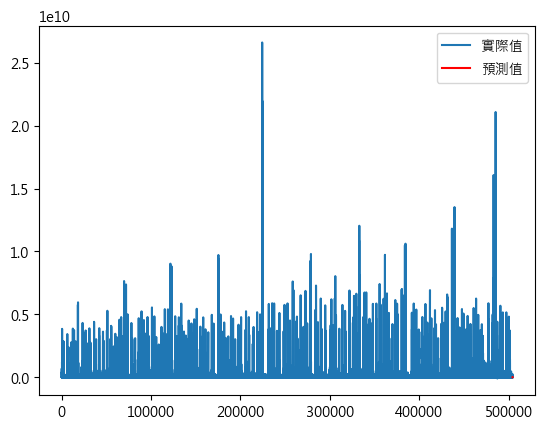

In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"

# 假設 df 是包含時間序列資料的資料框架
# 資料框架應該包含日期欄位和要預測的數值欄位
df = pd.read_csv("age.csv")

# 設定日期欄位為索引
df['年月'] = pd.to_datetime(df['年月'])
# 按照 '日期' 欄位進行排序
df = df.sort_values(by='年月')

# 重新設定索引
df = df.reset_index(drop=True)

# 將 '日期' 和 '信用卡交易金額' 欄位重命名，以符合 Prophet 的要求
df_prophet = df.rename(columns={'年月': 'ds', '信用卡交易金額[新台幣]': 'y'})


# 使用 ARIMA 模型進行預測
model = ARIMA(df['信用卡交易金額[新台幣]'], order=(1,1,1))  # 根據資料的情境調整 ARIMA 的參數
results = model.fit()

# 預測未來 n 個月
n = 12
forecast = results.get_forecast(steps=n)

# 繪製原始資料和預測值的趨勢圖
plt.plot(df['信用卡交易金額[新台幣]'], label='實際值')
plt.plot(forecast.predicted_mean, label='預測值', color='red')
plt.legend()
plt.show()


c:\GitHub\ctest\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


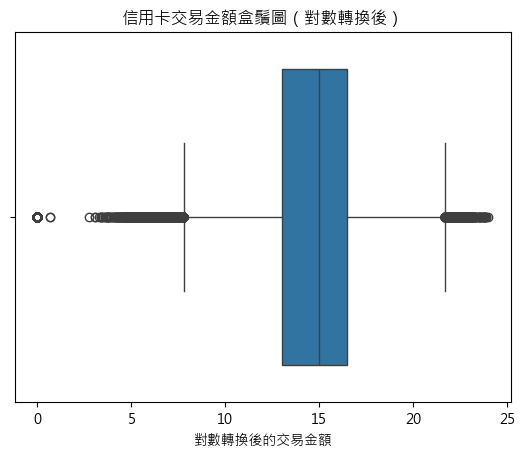

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假設 df 是包含 '信用卡交易金額' 和 '信用卡交易筆數' 欄位的資料框架
df = pd.read_csv("age.csv")

# 對交易金額進行對數轉換
df['log_信用卡交易金額'] = np.log1p(df['信用卡交易金額[新台幣]'])

# 繪製交易金額的盒鬚圖（對數轉換後）
sns.boxplot(x='log_信用卡交易金額', data=df)

# 加上標題和標籤
plt.title('信用卡交易金額盒鬚圖（對數轉換後）')
plt.xlabel('對數轉換後的交易金額')

# 顯示圖表
plt.show()


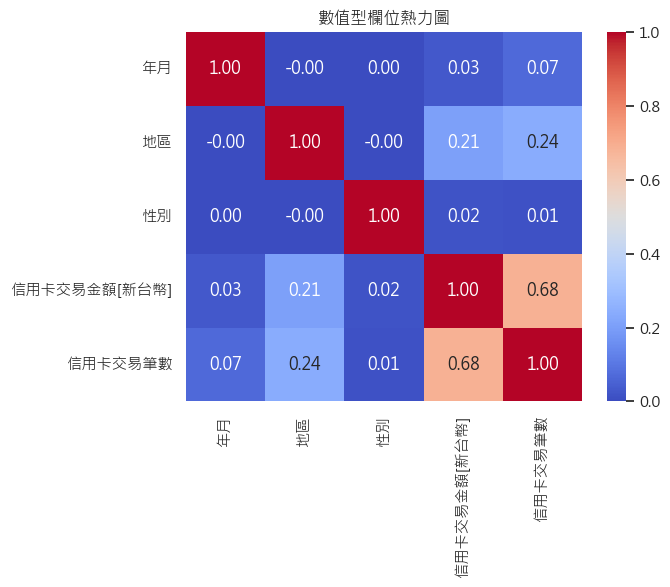

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.family"] = "Microsoft JhengHei"

# 假設 df 是包含 '信用卡交易金額[新台幣]' 和 '信用卡交易筆數' 欄位的資料框架
df = pd.read_csv("age.csv")

# 選擇要繪製熱圖的數值型欄位
numeric_columns = ['年月','地區','性別','信用卡交易金額[新台幣]', '信用卡交易筆數']

# 提取這些欄位的子集
df_numeric = df[numeric_columns]

# 使用 seaborn 繪製熱圖
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")

# 加上標題
plt.title('數值型欄位熱力圖')

# 顯示圖表
plt.show()
